<a href="https://colab.research.google.com/github/kevinmcmanus/lto_utils/blob/master/lto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LTO Utilities Library

The LTO Utilities library provides a set of useful functions for dealing with files output from the Little Thompson Observatory's radio telescope. These files, suffixed with '.lto' capture spectral information and the data processing pipeline produces them at approximately one-minute intervals throughout an observation.

For the purposes of this demo, a 24-hour drift scan observation is available in Google Cloud Storage.  Having the data in GCS complicates this demo somewhat in that the Google Colab virtual machine that is running this notebook needs to mount the GCS as a preliminary step.
The actual demonstration of obtaining and using the `lto_utils` library begins in the section entitled 'Clone the lto_utils' repo.

## Preliminaries

### References on Using Cloud Storage in Colab

These articles explain how to make Google Cloud Storage availabale within a Google Colab notebook, such as this one.

(https://medium.com/analytics-vidhya/how-to-access-files-from-google-cloud-storage-in-colab-notebooks-8edaf9e6c020)

(https://stackoverflow.com/questions/51715268/how-to-import-data-from-google-cloud-storage-to-google-colab)

(https://ostrokach.gitlab.io/post/google-colab-storage/)

### Authenticate and Mount GCS Bucket

In [27]:
from google.colab import auth

auth.authenticate_user()

In [28]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  26120      0 --:--:-- --:--:-- --:--:-- 26120
OK
54 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 54 not upgraded.
Need to get 4,278 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.30.0_amd64.deb ...
Unpacking gcsfuse (0.30.0) ...
Setting up gcsfuse (0.30.0) ...


In [29]:
#Mount the drive
!mkdir lto_data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 lto_data lto_data

Using mount point: /content/lto_data
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [ ]:
#to mount your own google drive, do this:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the lto_utils Repo

In [30]:
!git clone https://github.com/kevinmcmanus/lto_utils

fatal: destination path 'lto_utils' already exists and is not an empty directory.


In [31]:
import sys
sys.path.append('lto_utils')

In [32]:
import lto_utils.lto_file as lto

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read Single LTO File and Examine its Contents

In [34]:
#set the path to the object
path = 'lto_data/2018_09_02/LTO-HI-2018-09-02-17-41-53.lto'

#create an LTO_File object
lto_file = lto.LTO_File(path)


`lto_file` object contains two attributes: `SpectralHeader` and `SpectralData`. Both are large data structures. The `SpectralHeader` has several subsections which are:

In [35]:
lto_file.SpectralHeader.keys()

dict_keys(['Magic', 'Observatory', 'ObsLocation', 'BeamPosition', 'ObsTime', 'Spectrum', 'RadioCalibrations', 'ProgramControl', 'SpectralCharacteristics'])

 
The subsection `SpectralCharacteristics`  contains summary information of the file. 
 This subsection is particularly useful.

In [36]:
lto_file.SpectralHeader['SpectralCharacteristics']

{'avecrpwr': 1.5366042412277951e-21,
 'avefluxden': 13615.77330290577,
 'aveindvpwr': 0.0011540943523868918,
 'avespecpwr': 1.5385824373105864e-21,
 'avetsky': 111.4391098022461,
 'badspec': False,
 'numHIpwr': 326,
 'numave': 30112,
 'numbad': 0,
 'numcrpwr': 9421,
 'numspecpwr': 9747,
 'peakfluxden': 14932.340501863842,
 'peakfluxfreq': 1420362741.2578125,
 'peakpwr': 1.687354543606019e-21,
 'peakpwrfreq': 1420362741.2578125,
 'peaktsky': 122.21463458389968,
 'peaktskyfreq': 1420362741.2578125,
 'processing': 'Raw FFT',
 'totalHIpwr': 5.202144598592639e-19,
 'totalpwr': 1.4996563016466322e-17,
 'user': '',
 'varcrpwr': 5.002585095470724e-47,
 'varfluxden': 0.0,
 'varindvpwr': 1.4415335591877465e-10,
 'varspecpwr': 1.9838309232567554e-46,
 'vartsky': 0.0}

`SpectralData` is a  dictionary which essentially captures the spectrum and some other frequency-dependent measures.  Each dictionary element is a vector of length `nfft`.

In [37]:
lto_file.SpectralData.keys()

dict_keys(['dopfreq', 'rawavepwr', 'rawvarpwr', 'calavepwr', 'flatten', 'tsky', 'fluxden', 'badline', 'HIline'])

In [38]:
#type and length of the tsky member of the dictionary
n = len(lto_file.SpectralData['tsky'])
type(lto_file.SpectralData['tsky']), f'Length: {n}'

(numpy.ndarray, 'Length: 16385')

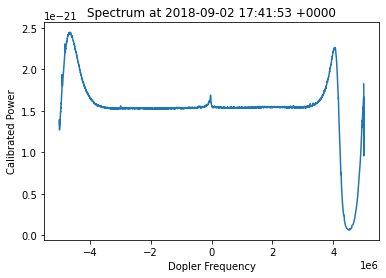

In [39]:
plt.plot(lto_file.SpectralData['dopfreq'], lto_file.SpectralData['calavepwr'])
plt.xlabel('Dopler Frequency')
plt.ylabel('Calibrated Power')
zz=plt.title('Spectrum at '+lto_file.get_time().strftime('%Y-%m-%d %H:%M:%S %z'))

Sometimes it's easier to work with a `Pandas` dataframe. The `LTO_File` class provides a method to do so.

In [40]:
import pandas as pd
pd_df = lto_file.to_pandas()
pd_df.head()

,ts,ra,dec,dopfreq,rawavepwr,rawvarpwr,calavepwr,flatten,tsky,fluxden,badline,HIline
0,2018-09-02 17:41:53+00:00,9.463691,-28.649834,-5000000.0,0.000928,8.694844e-07,1.331449e-21,0.869181,96.436501,11782.735352,True,False
1,2018-09-02 17:41:53+00:00,9.463691,-28.649834,-4999389.5,0.000921,8.584904e-07,1.393561e-21,0.869213,100.935272,12332.401367,True,False
2,2018-09-02 17:41:53+00:00,9.463691,-28.649834,-4998779.5,0.000934,8.577524e-07,1.329013e-21,0.869245,96.260063,11761.179688,True,False
3,2018-09-02 17:41:53+00:00,9.463691,-28.649834,-4998169.0,0.000937,8.678040e-07,1.297855e-21,0.869278,94.003265,11485.439453,True,False
4,2018-09-02 17:41:53+00:00,9.463691,-28.649834,-4997558.5,0.000940,8.779941e-07,1.277373e-21,0.869310,92.519798,11304.188477,True,False


**TODO:** check out the ra and dec columns above

##Read All LTO Files in a Directory

`lto_utils` provides functionality to read all `.lto` in a directory. This can useful in summarizing an observing session, such as a drift scan.

**Caution:** the methods below will read **all** `.lto` files in the specified directory, so if there are files with duplicate content or `.lto` files from other observing sessions, such files will contaminate the results.

In [41]:
# see the directories of observations:
!ls lto_data

2018_08_30  2018_09_02


These are early observations in the LTO Radio Telescope projects. As such, the quality of the data is suspect; however the observations will suffice for demonstration purposes.  Just don't base any science on these!!

The 2018_08_30 directory is a 24-hour drift scan, some 1440 files (one for each minute) in all.  The 2018_09_02 observation set is considerably smaller, so we'll demonstrate with it.  Doing so, however will compromise the plots that follow.

If you want to see a full 24-hour drift scan, set the scan date to `'2018_08_30'`.

In [56]:
#obs_dir = '/Users/kevin/Documents/LTO Radiometry/HI_Detection/lto_cache'
obs_dir = 'lto_data'
scan_date = '2018_08_30'

In [ ]:
#get all the spectral characteristics for the observation of 2018_09_02
# this can take a several minutes to run, espcially if the files are not local
obs_summary = lto.getSpectralCharacteristics(obs_dir+ '/' +scan_date)

In [ ]:
obs_summary.head()

In [46]:
len(obs_summary)

243

Text(0, 0.5, 'Average Sky Temp (K)')

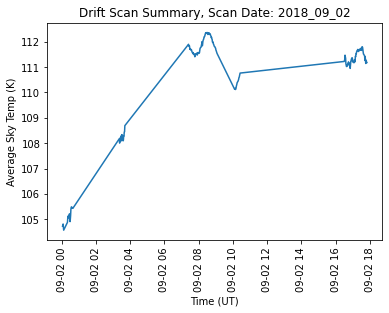

In [47]:
plt.plot(obs_summary.index, obs_summary.avetsky)
plt.title(f'Drift Scan Summary, Scan Date: {scan_date}')
plt.xlabel('Time (UT)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')

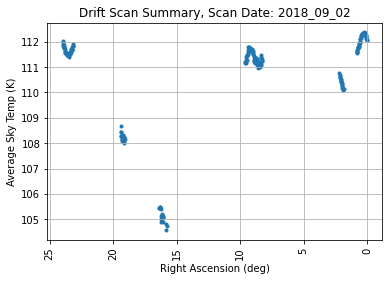

In [48]:
#it's a drift scan so plot by right ascension
plt.scatter(obs_summary.ra, obs_summary.avetsky, s=9)
plt.title(f'Drift Scan Summary, Scan Date: {scan_date}')
plt.xlabel('Right Ascension (deg)')
plt.xticks(rotation=90)
plt.ylabel('Average Sky Temp (K)')
plt.grid()
plt.gca().invert_xaxis()

In [ ]:
#this takes quite a bit of time on goolge, not so much when data is local

#get all the spectral data from the drift scan
#spectra = lto.getDriftScan(obs_dir+ '/' +scan_date)

In [ ]:
spectra.head()

,ts,ra,dec,dopfreq,rawavepwr,rawvarpwr,calavepwr,flatten,tsky,fluxden,badline,HIline
0,2018-09-02 00:03:01+00:00,15.767594,-28.649834,-5000000.0,0.000870,7.603490e-07,1.057410e-21,0.869181,76.587936,9357.613281,True,False
1,2018-09-02 00:03:01+00:00,15.767594,-28.649834,-4999389.5,0.000887,7.864655e-07,9.077309e-23,0.869213,6.574670,803.301636,True,False
2,2018-09-02 00:03:01+00:00,15.767594,-28.649834,-4998779.5,0.000887,7.763921e-07,6.609310e-22,0.869245,47.871052,5848.946777,True,False
3,2018-09-02 00:03:01+00:00,15.767594,-28.649834,-4998169.0,0.000871,7.660552e-07,8.888164e-22,0.869278,64.376732,7865.631836,True,False
4,2018-09-02 00:03:01+00:00,15.767594,-28.649834,-4997558.5,0.000885,7.746120e-07,1.064691e-21,0.869310,77.115265,9422.042969,True,False


Yeilds a rather large data frame:

In [ ]:
len(spectra)

3981555

## Construct a Spectrogram

The `spectra` data frame from above can be unweildy with 23 million rows, so the `getDriftScan` method provides a `dfclip` parameter to eliminate data at the far ends of the spectrum. If we clip the spectrum, the production of the spectrogram proceeds much faster, because the resulting data set is so much smaller.

In [52]:
#clip to -300 kHz to 300 kHz
spectra = lto.getDriftScan(obs_dir+ '/' +scan_date, dfclip=(-0.3e6, 0.3e6))
len(spectra)

238869

In [53]:
#make the temperature array dopfreq x time

#sort the spectra data frame
spectra.sort_values(['dopfreq', 'ts'], inplace=True)

#get the y axis (dopler freq) values:
dopfreqs = spectra.dopfreq.unique()

# next, get the x-axis which is the time of the observations;
obs_times = spectra.ts.unique()

#make the temperature array
skytemp = np.array(spectra.tsky).reshape(len(dopfreqs), len(obs_times))

skytemp.shape

(983, 243)

In [54]:
#helper routine to beautify the time formating:
import matplotlib.dates as mdates
fmt = mdates.DateFormatter('%H:%M')

#for the normalizer:
import matplotlib.colors as colors



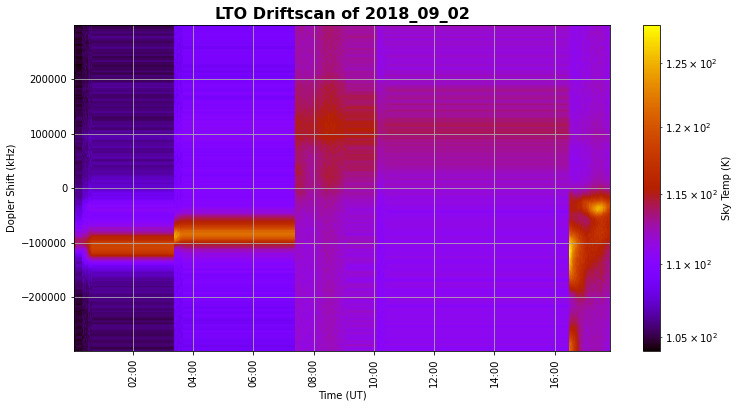

In [55]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()

pcm = ax.pcolormesh(obs_times, dopfreqs, skytemp,cmap='gnuplot',
                norm=colors.LogNorm())
                   #norm=colors.PowerNorm(gamma=1./2.))
fig.colorbar(pcm, label='Sky Temp (K)')

plt.xlabel('Time (UT)')
plt.gca().xaxis.set_major_formatter(fmt)
plt.xticks(rotation=90)
plt.ylabel('Dopler Shift (kHz)')
plt.title(f'LTO Driftscan of {scan_date}',fontdict={'fontsize':16, 'fontweight':'bold'})
plt.grid()